# Preamble

**BEFORE RUNNING THIS CODE: **Download the launch 12 GPS data [here](https://github.com/psas/Launch-12/blob/gh-pages/data/GPS/JGPS%40-32.041913222), and place it in the */resources* folder.

This notebook demonstrates the satellite acquisition proccess, in which we determine which satellites are overhead. This code implements the parallel code phase search algorithm, which is the most complex of those available, but is also the fastest since it returns a result in just one iteration. It is possible that we will need to use a different algorithm when the code is running on an embedded platform.

**Note: we should only perform this acquisition method on ~20ms sections of data, see book for details**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct
import math

##Grabs the GoldCode module from the root of the repo
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from GoldCode import GoldCode

# Start of ByteToIQPairs Function
def ByteToIQPairs( TheByte ):
    IQPairs = []
    
    # This code reads each of the four pairs of bits from the byte 
    # and determines the sign and magnitude. Then it returns a list 
    # containing two pairs of IQ data as floating point [I1,Q1,I2,Q2].
    # For magnitude: a bit value of 1 means mag 1, 0 means mag 1/3
    # For sign: a bit value of 1 means negative, 0 means positive
    # This interpretation was taken by the sample code provided
    # in the PSAS Launch12 github repo (example was provided in C)
    #
    # f_s = 4.092 MHz (sampling rate of raw signal)
   
    IMag1 = (TheByte >> 7) & (0b00000001)
    ISign1 = (TheByte >> 6) & (0b00000001)
    I1 = 1.0 if (IMag1 == 1) else 1.0/3.0
    I1 = -I1 if (ISign1 == 1) else I1
    IQPairs.append(I1)
    
    QMag1 = (TheByte >> 5) & (0b00000001)
    QSign1 = (TheByte >> 4) & (0b00000001)
    Q1 = 1.0 if (QMag1 == 1) else 1.0/3.0
    Q1 = -Q1 if (QSign1 == 1) else Q1
    IQPairs.append(Q1)    
        
    IMag2 = (TheByte >> 3) & (0b00000001)
    ISign2 = (TheByte >> 2) & (0b00000001)
    I2 = 1.0 if (IMag2 == 1) else 1.0/3.0
    I2 = -I2 if (ISign2 == 1) else I2
    IQPairs.append(I2)    
        
    QMag2 = (TheByte >> 1) & (0b00000001)
    QSign2 = (TheByte >> 0) & (0b00000001)
    Q2 = 1.0 if (QMag2 == 1) else 1.0/3.0
    Q2 = -Q2 if (QSign2 == 1) else Q2
    IQPairs.append(Q2)
    
    return IQPairs 
# End of ByteToIQPairs Function


# Import data File

In [2]:
# Beginning of main code
# Open data file
# Information on file "JGPS@-32.041913222" can be found at: 
# https://github.com/psas/Launch-12/tree/gh-pages/data/GPS
print("Opening a file.")
fHandle = open('../resources/JGPS@-32.041913222','r', encoding = 'utf-8', errors = 'ignore')
print("File handle is: %d." % (fHandle.fileno()))

# Read file one byte at a time, extract the two 
# IQ pairs, and store in array, after conversion to float.
# Will initially read enough samples for ~20 ms of data
fs = 4.092*10**6 # Sampling Frequency [Hz]
Ts = 1/fs # Sampling Period [s]
SampleLength = 20*10**(-3) # 20 ms Sample length
StartingByte = 1 # Can change this if we want to discard initial samples
TotalSamples = int(np.ceil(SampleLength/Ts)) 
TotalBytes = int(np.ceil(TotalSamples/2))
print("Total Bytes read: %d." %(TotalBytes))
print("Which equals %d IQ pairs." %(TotalBytes*2))
print("Sample Length: %f seconds." %(TotalBytes*2*Ts))

i = StartingByte
SingleByte = fHandle.read(1)
IData = []
QData = []
while SingleByte != "":
    IQPairs = ByteToIQPairs(ord(SingleByte))
    IData.append(IQPairs[0])
    IData.append(IQPairs[2])
    QData.append(IQPairs[1])
    QData.append(IQPairs[3])
    #print("I: %f, Q: %f ." % (IQPairs[0], IQPairs[1]))
    #print("I: %f, Q: %f ." % (IQPairs[2], IQPairs[3]))
    
    i += 1
    if i > (TotalBytes - StartingByte):
        break
    SingleByte = fHandle.read(1)

fHandle.close()
print("File is now closed.")

Opening a file.
File handle is: 52.
Total Bytes read: 40920.
Which equals 81840 IQ pairs.
Sample Length: 0.020000 seconds.
File is now closed.


# Convert to complex array

In [3]:
print("length of IData is: %d" % (len(IData)))
print("Length of QData is: %d" % (len(QData)))

CData = np.zeros(len(IData), dtype=np.complex)

for d in range(len(IData)):
	CData[d] = IData[d] + QData[d] * 1j
    
#print(CData)

length of IData is: 81838
Length of QData is: 81838


# LO Sweep

- Between these 2 steps we need to sweep the local oscillator due to Doppler effect
- Pick a frequency, and run the steps from here assuming the Doppler shift puts us @ that freq
- We need to multiply the incoming data by a complex sine wave 
- The frequency of the generated wave is equal to the difference between the actual and target frequencies
- The sine wave must be complex in order to get a negative frequency (sweep both directions)
- Book recommends +/- 10kHz in 500Hz steps (pg 77)

# Take fft

In [4]:
# Need deltaFreq to be 500 Hz
deltaFreq = 500 # Hz

# Determine which FFT length will give ~500 Hz frequency resolution.
nfft = int(np.ceil(fs/deltaFreq)) # fs is initialized in Import Data File section
print("nfft (FFT length) for %d Hz: %d" %(deltaFreq, nfft))
print("Calculated deltaFreq: %f" %(fs/nfft))

# Generate frequency lists for plotting fft
# Can use f for regular fft and fshift for shifted version
fs_kHz = fs/1000 #Make easier to read
f = np.linspace (0,fs_kHz,nfft, endpoint=False)
fshift = np.linspace(-fs_kHz/2,fs_kHz/2,nfft,endpoint=False)

# Reference data size section of book to pick the len param. Should be based sample rate
ffC = np.fft.fft(CData, nfft)

nfft (FFT length) for 500 Hz: 8184
Calculated deltaFreq: 500.000000


# Plot output

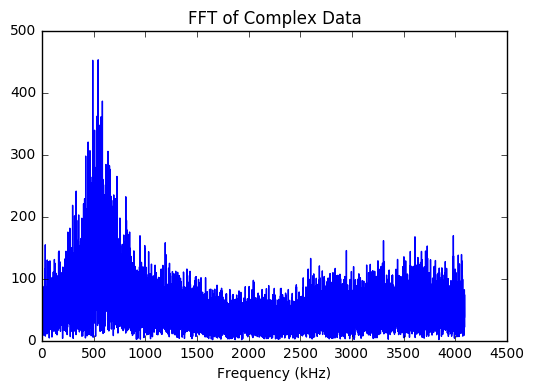

In [5]:
plt.plot(f, np.abs(ffC))

plt.title("FFT of Complex Data")
plt.xlabel("Frequency (kHz)")
plt.show()

# Get a Gold Code

- Gold Code must be generated as though it were sampled at the sampling rate
- 1023 chips that must take 1ms to pass through (due to chipping rate)
- We are sampling @ 4.092 MHz
- So we need the GC to repeat each chip 4 times before going to the next chip.

- The numpy.repeat() function does this exactly

In [6]:
sat = (7, 9)

CodeGen = GoldCode(sat)
code = np.repeat(CodeGen.getCode(1023), 4)

# Reformat GC to have -1 in place of 0
for n,i in enumerate(code):
    if i==0:
        code[n]=-1


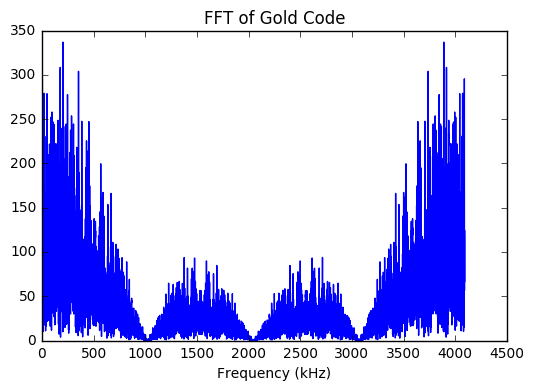

In [7]:
Codefft = np.fft.fft(code, nfft)

plt.plot(f, np.abs(Codefft))
plt.title("FFT of Gold Code")
plt.xlabel("Frequency (kHz)")
plt.show()

# Complex Conjugate of Gold Code fft

real(fft) - imag(fft)j

Length of t: 8184
Length of IFFT: 8184


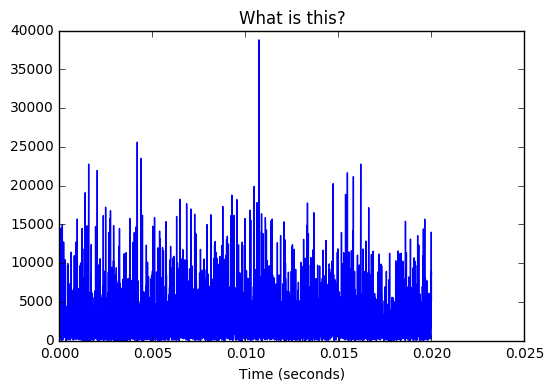

In [8]:
GCConj = np.conjugate(Codefft)

result = np.fft.ifft(GCConj * ffC,nfft)

resultSQ = np.abs(result) ** 2

t = np.linspace(0,0.020,nfft,endpoint=True) 
print("Length of t: %d" %(len(t)))
print("Length of IFFT: %d" %(len(resultSQ)))

plt.plot(t,resultSQ)
plt.title("What is this?")
plt.xlabel("Time (seconds)")
plt.show()

# Notes

- From book appendix: we should look for the top 2 peaks, and use the ratio to determine whether there is a signal or just noise
- We should get the C code running and be sure to compare results. Acquisition works in the C code, but tracking is untested